In [ ]:
!pip install wordcloud

In [3]:
%pip install pycaret

zsh:1: no matches found: pycaret[models]
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import requests
import xgboost
from urllib import parse
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

### Data Importing

In [2]:
data = pd.read_csv('학습셋_A트랙/A Track 학습셋.csv')
data.head(3)

,Log_Number,payload,label_action
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Log_Number    45000 non-null  int64 
 1   payload       45000 non-null  object
 2   label_action  45000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


### URL Decoding

In [4]:
data.loc[1]['payload']

'POST /owa/auth/logon.aspx?replaceCurrent=1%22%29%20AND%209294%3DUTL_INADDR.GET_HOST_ADDRESS%28CHR%28113%29%7C%7CCHR%28112%29%7C%7CCHR%2898%29%7C%7CCHR%28120%29%7C%7CCHR%28113%29%7C%7C%28SELECT%20%28CASE%20WHEN%20%289294%3D9294%29%20THEN%201%20ELSE%200%20END%29%20FROM%20DUAL%29%7C%7CCHR%28113%29%7C%7CCHR%28122%29%7C%7CCHR%28106%29%7C%7CCHR%28107%29%7C%7CCHR%28113%29%29%20AND%20%28%22tdDX%22%3D%22tdDX&reason=3&url= HTTP/1.1\\r\\nContent-Length: 0\\r\\nCache-Control: no-cache\\r\\nUser-Agent: sqlmap/1.6.7#stable (https://sqlmap.org)\\r\\nReferer: http://owa.college.school:80/owa/auth/logon.aspx\\r\\nHost: owa.college.school\\r\\nAccept: */*\\r\\nAccept-Encoding: gzip,deflate\\r\\nContent-Type: application/x-www-form-urlencoded; charset=utf-8\\r\\nConnection: close\\r\\n\\r\\n'

In [5]:
parse.unquote(data.loc[1]['payload'])

'POST /owa/auth/logon.aspx?replaceCurrent=1") AND 9294=UTL_INADDR.GET_HOST_ADDRESS(CHR(113)||CHR(112)||CHR(98)||CHR(120)||CHR(113)||(SELECT (CASE WHEN (9294=9294) THEN 1 ELSE 0 END) FROM DUAL)||CHR(113)||CHR(122)||CHR(106)||CHR(107)||CHR(113)) AND ("tdDX"="tdDX&reason=3&url= HTTP/1.1\\r\\nContent-Length: 0\\r\\nCache-Control: no-cache\\r\\nUser-Agent: sqlmap/1.6.7#stable (https://sqlmap.org)\\r\\nReferer: http://owa.college.school:80/owa/auth/logon.aspx\\r\\nHost: owa.college.school\\r\\nAccept: */*\\r\\nAccept-Encoding: gzip,deflate\\r\\nContent-Type: application/x-www-form-urlencoded; charset=utf-8\\r\\nConnection: close\\r\\n\\r\\n'

In [6]:
data['decoded_payload'] = data['payload'].apply(lambda x: parse.unquote(x))

In [7]:
data['decoded_payload'].to_csv('decoded_payload.csv', index=False)

### Data nan check

In [8]:
data.isnull().sum()

Log_Number         0
payload            0
label_action       0
decoded_payload    0
dtype: int64

### Data Length check

In [9]:
max_length = max(len(payload) for payload in data['decoded_payload'])
total_length = sum(len(payload) for payload in data['decoded_payload'])
average_length = total_length / len(data['decoded_payload'])
print("최대길이 : ", max_length)
print("평균길이 : ", average_length)

최대길이 :  7127
평균길이 :  510.6442222222222


### Data Label Check

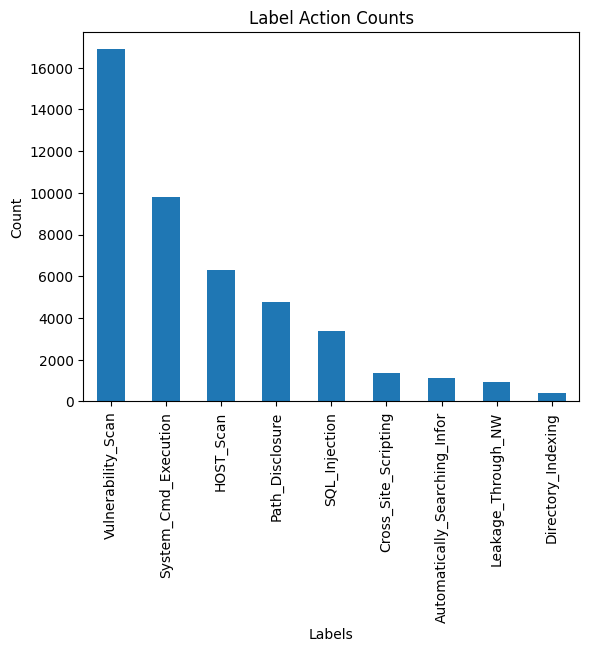

In [10]:
# 'label_action' 열의 라벨 개수를 세고, 그 결과를 시각화합니다.
label_counts = data['label_action'].value_counts()

# 막대 그래프를 그립니다.
label_counts.plot(kind='bar')

# 그래프에 제목과 축 레이블을 추가합니다.
plt.title('Label Action Counts')
plt.xlabel('Labels')
plt.ylabel('Count')

# 그래프를 표시합니다.
plt.show()

In [13]:
def draw_wordcloud(df, label_name):
  filtered_df = df[df['label_action'] == label_name]
  text = ' '.join(filtered_df['decoded_payload'].astype(str))
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for {label_name}', fontsize=20)
  plt.show()

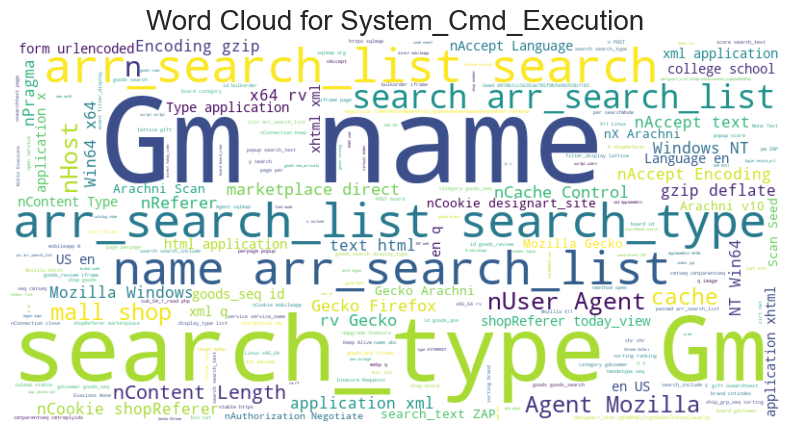

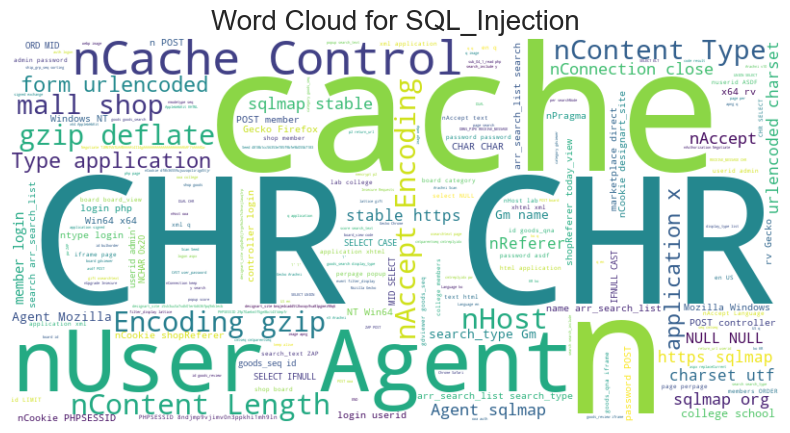

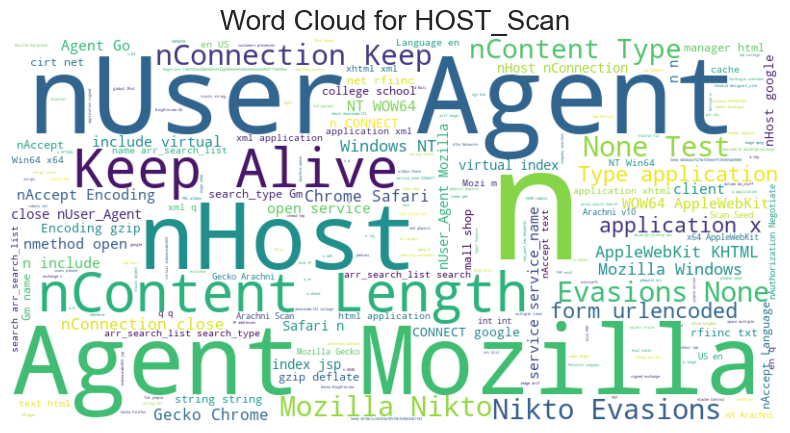

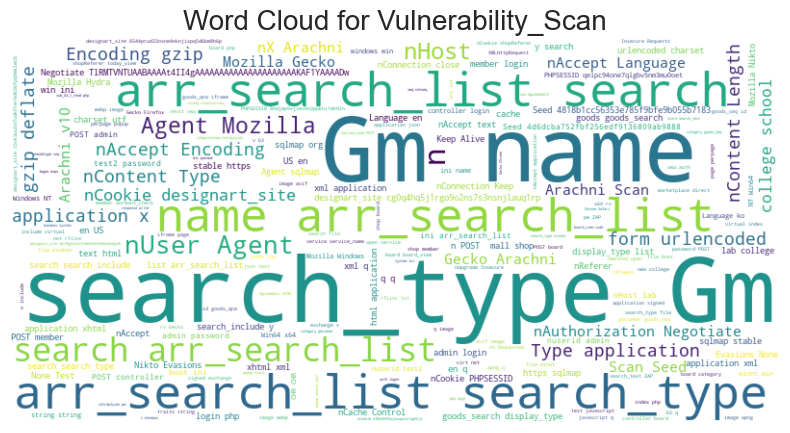

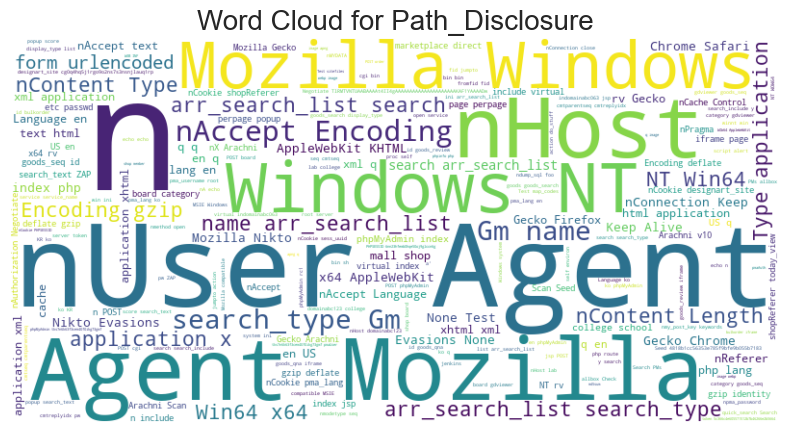

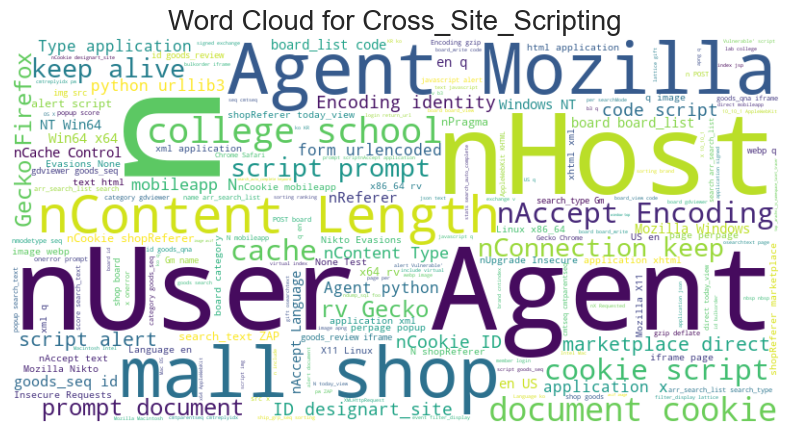

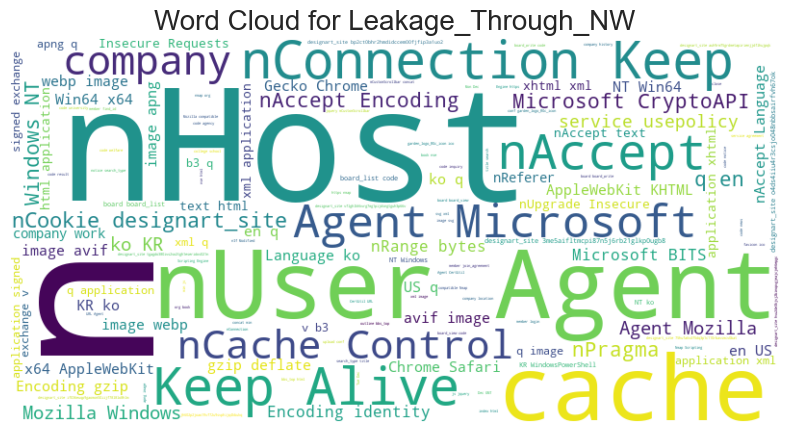

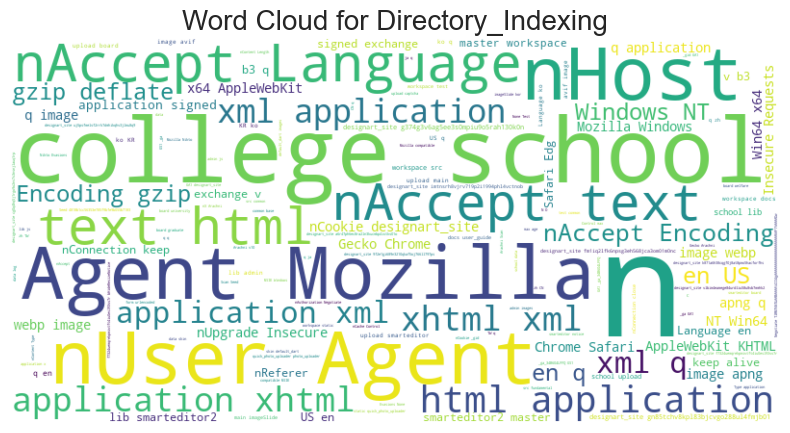

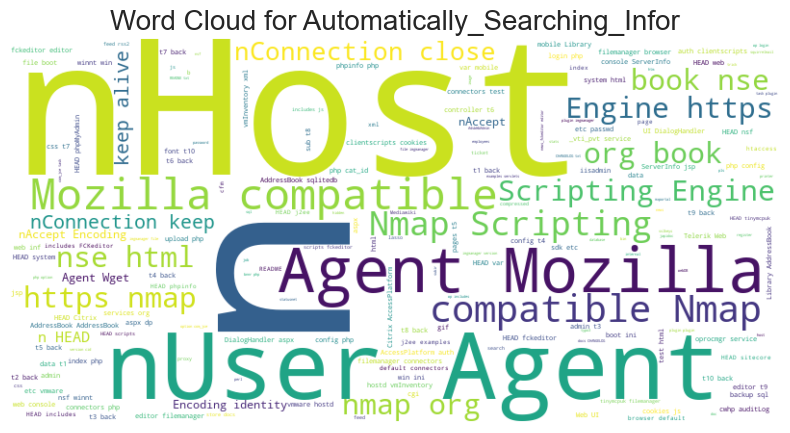

In [10]:
for i in range(data.label_action.nunique()):
  label_name = data.label_action.unique()[i]
  draw_wordcloud(data, label_name)

### 라벨별 특성 확인해보기

## Feature Engineering custom Features
- length of payload
- number of non-printable characters in payload
- number of punctuation characters in payload
- the minimum byte value of payload
- the maximum byte value of payload
- the mean byte value of payload
- the standard deviation of payload byte values
- number of distinct bytes in payload
- number of SQL keywords in payload
- number of javascript keywords in payload

In [25]:
def plot_feature_distribution(features):
  print('Properties of feature: ' + features.name)
  print(features.describe())
  f, ax = plt.subplots(1, figsize=(10, 6))
  ax.hist(features, bins=features.max()-features.min()+1, density=False)  # "normed" 대신 "density" 사용
  ax.set_xlabel('value')
  ax.set_ylabel('fraction')
  plt.show()
  
def create_feature_length(payloads):
  payloads['length'] = [len(str(row)) for row in payloads['decoded_payload'] ]
  return payloads

,Log_Number,payload,label_action,decoded_payload,length
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752


Properties of feature: length
count    45000.000000
mean       510.644222
std        436.683580
min         22.000000
25%        247.000000
50%        359.000000
75%        631.000000
max       7127.000000
Name: length, dtype: float64


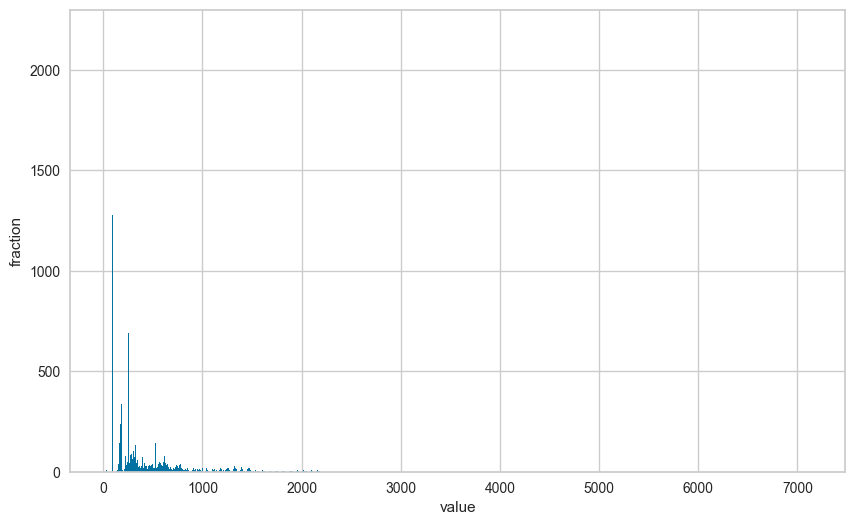

In [26]:
data = create_feature_length(data)
display(data.head(3))
plot_feature_distribution(data['length'])

,Log_Number,payload,label_action,decoded_payload,length,non-printable
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0


Properties of feature: non-printable
count    45000.000000
mean         0.114222
std          1.702820
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        135.000000
Name: non-printable, dtype: float64


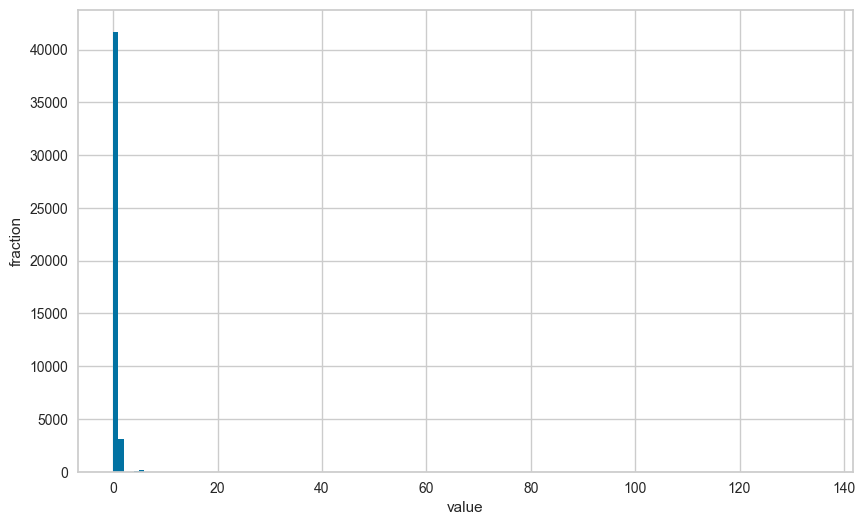

In [31]:
def create_feature_nonprintable(payloads):
  payloads['non-printable'] = [len([1 for letter in str(row) if letter not in string.printable]) for row in payloads['decoded_payload']]
  return payloads

data = create_feature_nonprintable(data)
display(data.head(3))

plot_feature_distribution(data['non-printable'])

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146


Properties of feature: punctuation
count    45000.000000
mean       134.190400
std        185.787394
min          7.000000
25%         43.000000
50%         78.000000
75%        149.000000
max       1500.000000
Name: punctuation, dtype: float64


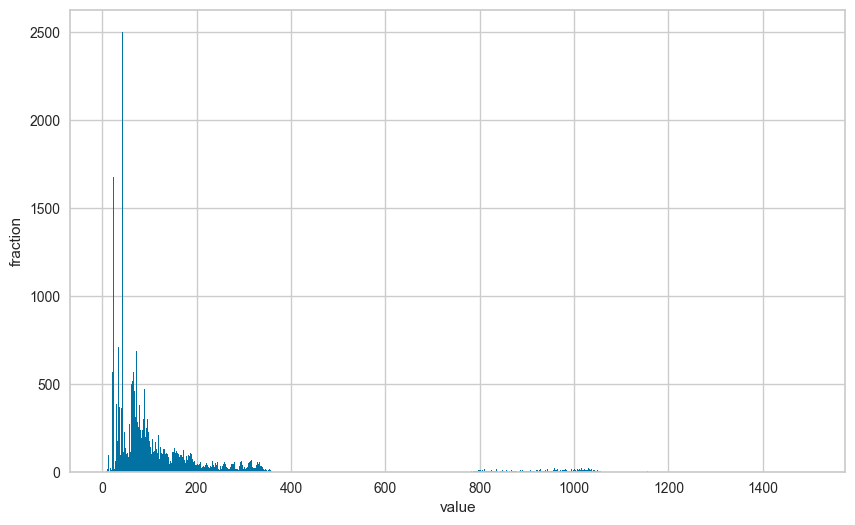

In [32]:
def create_feature_punchualchar(payloads):
  data['punctuation'] = [len([1 for letter in str(row) if letter in string.punctuation])  for row in data['decoded_payload']]
  return payloads

data = create_feature_punchualchar(data)
display(data.head(3))

plot_feature_distribution(data['punctuation'])

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32


Properties of feature: min-byte
count    45000.000000
mean        29.698311
std          8.188023
min          0.000000
25%         32.000000
50%         32.000000
75%         32.000000
max         32.000000
Name: min-byte, dtype: float64


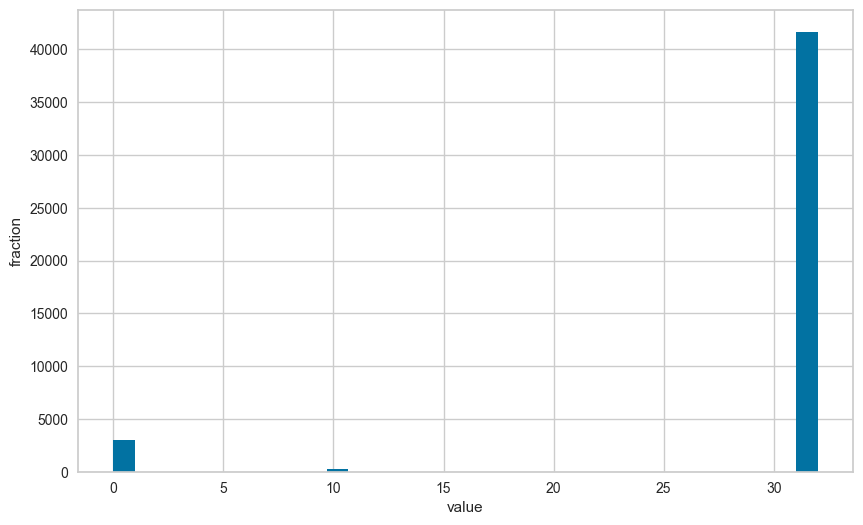

In [33]:
# minimum byte value of payload
def create_feature_minbyte(payloads):
  data['min-byte'] = [min(bytearray(str(row),'utf-8')) for row in data['decoded_payload']]
  return payloads

data = create_feature_minbyte(data)
display(data.head(3))
plot_feature_distribution(data['min-byte']) 

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,124,75.714849
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,85.923077


Properties of feature: max-byte
count    45000.000000
mean       122.589000
std          8.753255
min        114.000000
25%        122.000000
50%        122.000000
75%        122.000000
max        239.000000
Name: max-byte, dtype: float64


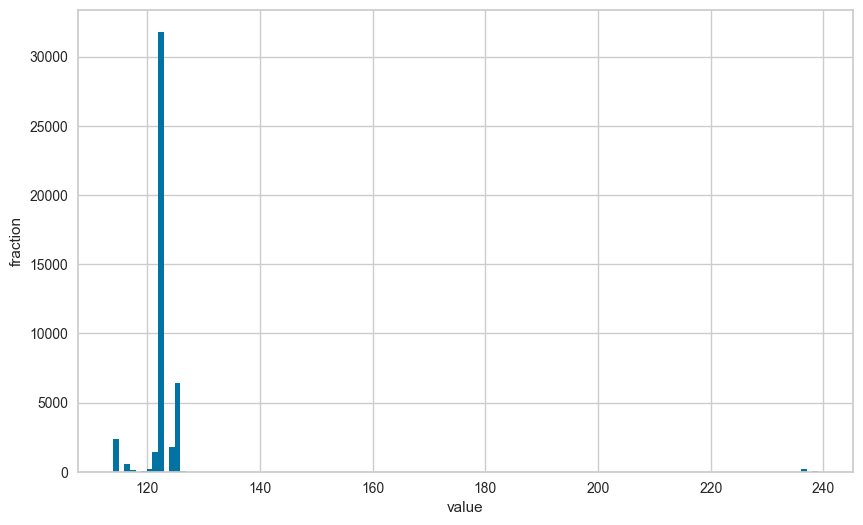

In [36]:
#max byte feature# maximum byte value of payload
def create_feature_maxbyte(payloads):
  data['max-byte'] = [max(bytearray(str(row),'utf-8')) for row in data['decoded_payload']]
  return payloads

data = create_feature_maxbyte(data)
display(data.head(3))
plot_feature_distribution(data['max-byte']) 

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,124,83.505654
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,89.618351


Properties of feature: mean-byte
count    45000.000000
mean        84.932467
std          5.230477
min         60.000000
25%         82.000000
50%         86.000000
75%         89.000000
max        100.000000
Name: mean-byte, dtype: float64


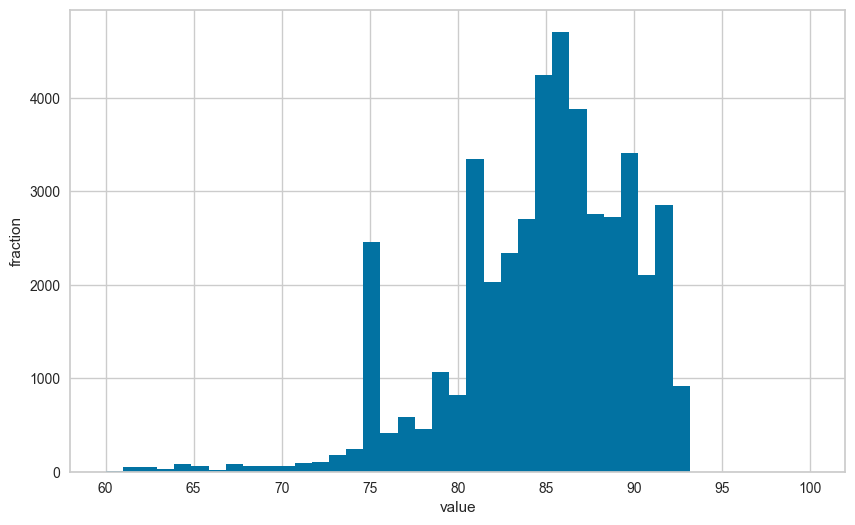

In [37]:
#mean byte value of payload
def create_feature_meanbyte(payloads):
  data['mean-byte'] = [np.mean(bytearray(str(row),'utf-8')) for row in data['decoded_payload']]
  return payloads

data = create_feature_meanbyte(data)
display(data.head(3))
plot_feature_distribution(data['mean-byte'].astype(int))

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583,27.382379
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,124,83.505654,28.499999
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,89.618351,25.340644


Properties of feature: std-byte
count    45000.000000
mean        26.706756
std          1.754001
min          7.000000
25%         26.000000
50%         27.000000
75%         28.000000
max         51.000000
Name: std-byte, dtype: float64


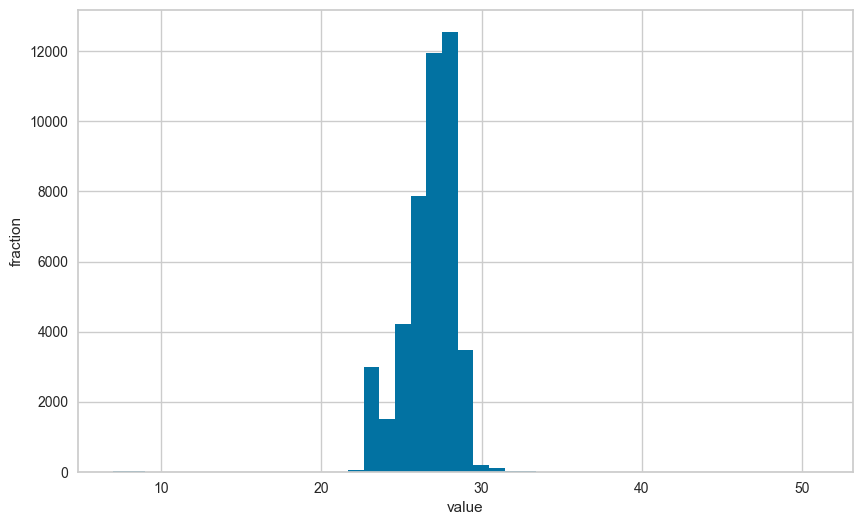

In [38]:
#standard deviation of byte value of payload
def create_feature_stdbyte(payloads):
  data['std-byte'] = [np.std(bytearray(str(row),'utf-8')) for row in data['decoded_payload']]
  return payloads

data = create_feature_stdbyte(data)
display(data.head(3))
plot_feature_distribution(data['std-byte'].astype(int))

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583,27.382379,70
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,122,83.505654,28.499999,69
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,89.618351,25.340644,75


Properties of feature: distinct-byte
count    45000.000000
mean        58.623733
std         15.975363
min         12.000000
25%         54.000000
50%         62.000000
75%         70.000000
max        105.000000
Name: distinct-byte, dtype: float64


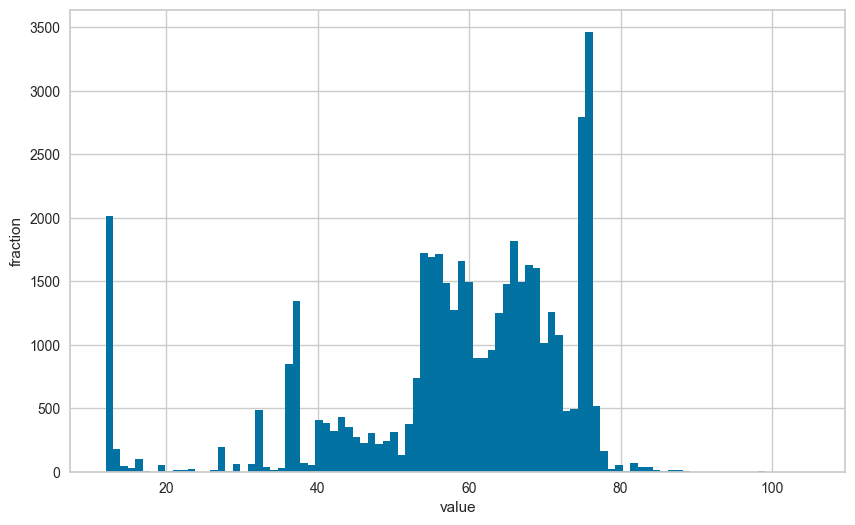

In [40]:
#distinct byte value of payload
def create_feature_dstbyte(payloads):
  data['distinct-byte'] = [len(set(bytearray(str(row),'utf-8'))) for row in data['decoded_payload']]
  return payloads

data = create_feature_dstbyte(data)
display(data.head(3))
plot_feature_distribution(data['distinct-byte'].astype(int))


pandas.core.frame.DataFrame

,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583,27.382379,70,11
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,122,83.505654,28.499999,69,14
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,89.618351,25.340644,75,6


Properties of feature: sql-keywords
count    45000.000000
mean         6.329467
std          3.784147
min          0.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         62.000000
Name: sql-keywords, dtype: float64


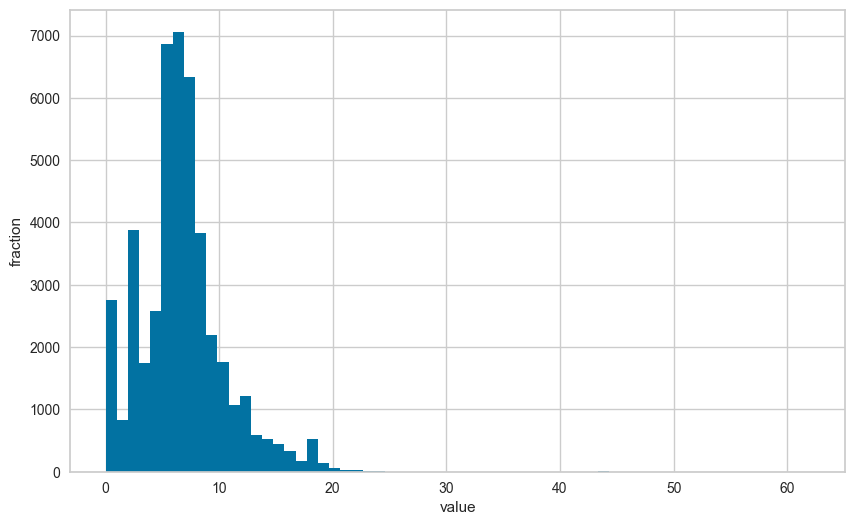

In [42]:
#number of SQL keywords in payload
sql_keywords = pd.read_csv('https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/435e639346787ce2b495a16e9f690ef5/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):
    data['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in data['decoded_payload']]
    return payloads

create_feature_sql_keywords(data)
display(type(sql_keywords))
display(data.head(3))
plot_feature_distribution(data['sql-keywords'])

,Keyword
0,abstract
1,arguments
2,await*
3,boolean
4,break
...,...
143,textarea
144,top
145,unescape
146,untaint


,Log_Number,payload,label_action,decoded_payload,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
0,0,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",System_Cmd_Execution,"GET /forum1_professionnel.asp?n=/.\\\""./.\\\""....",480,0,132,32,124,88.239583,27.382379,70,11,6
1,1,POST /owa/auth/logon.aspx?replaceCurrent=1%22%...,System_Cmd_Execution,"POST /owa/auth/logon.aspx?replaceCurrent=1"") A...",619,0,143,32,122,83.505654,28.499999,69,14,7
2,2,GET /goods/goods_search?display_type=list&arr_...,SQL_Injection,GET /goods/goods_search?display_type=list&arr_...,752,0,146,32,122,89.618351,25.340644,75,6,2


Properties of feature: js-keywords
count    45000.000000
mean         4.000311
std          2.641149
min          0.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         26.000000
Name: js-keywords, dtype: float64


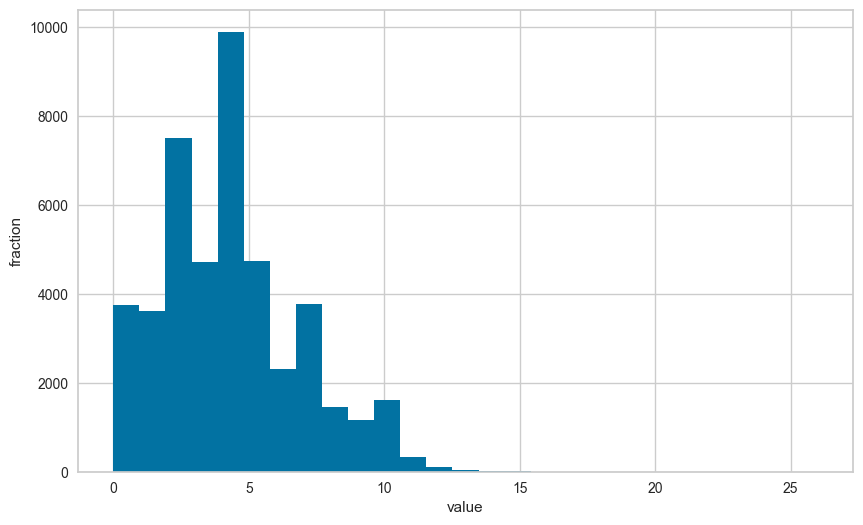

In [44]:
# javascript key word is presten or not in payload
js_keywords = pd.read_csv("https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/dedc7eb9846a30c252cd950a0e2153d9/JavascriptKeywords.txt",index_col=False)
def create_feature_javascript_keywords(payloads):
  data['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in data['decoded_payload']]
  return payloads
display(js_keywords)
data = create_feature_javascript_keywords(data)
display(data.head(3))
plot_feature_distribution(data['js-keywords'])

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(data['decoded_payload'], data['label_action'], stratify = data['label_action'], 
                                                    test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# 분할된 데이터프레임의 인덱스를 초기화합니다.
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_transformed.shape, X_test_transformed.shape

((36000, 1000), (9000, 1000))

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(data['decoded_payload'], data['label_action'], stratify = data['label_action'], 
                                                    test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.3, analyzer='char', sublinear_tf=True, ngram_range=(1,3), max_features=1000)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# 분할된 데이터프레임의 인덱스를 초기화합니다.
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(X_train_transformed.shape, X_test_transformed.shape)

# X_train_transformed을 DataFrame으로 변환
X_train_df = pd.DataFrame(X_train_transformed.toarray())

# X_test_transformed을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test_transformed.toarray())

((36000, 1000), (9000, 1000))

In [86]:
# X_train_transformed을 DataFrame으로 변환
X_train_df = pd.DataFrame(X_train_transformed.toarray())

# X_test_transformed을 DataFrame으로 변환
X_test_df = pd.DataFrame(X_test_transformed.toarray())

In [52]:
from sklearn.preprocessing import MinMaxScaler

custom_feature_df = data.drop(columns=['payload', 'decoded_payload', 'label_action', 'Log_Number'], axis=1)
scaler = MinMaxScaler()
custom_feature_df = pd.DataFrame(scaler.fit_transform(custom_feature_df), columns=custom_feature_df.columns)

In [54]:
custom_feature_df.head(3)

,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
0,0.064462,0.0,0.083724,1.0,0.123457,0.685094,0.448984,0.623656,0.177419,0.230769
1,0.084025,0.0,0.091092,1.0,0.098765,0.567516,0.474210,0.612903,0.225806,0.269231
2,0.102745,0.0,0.093101,1.0,0.098765,0.719339,0.402899,0.677419,0.096774,0.076923


In [55]:
merged_df = pd.concat([X_train_df, custom_feature_df.iloc[X_train.index]], axis=1)

In [13]:
from pycaret.classification import *

### No Add Custom Features

In [87]:
clf1 = setup(data=pd.concat([X_train_df, y_train], axis=1), target = 'label_action', session_id=2023, fold=5, n_jobs=-1)

,Description,Value
0,Session id,2023
1,Target,label_action
2,Target type,Multiclass
3,Target mapping,"Automatically_Searching_Infor: 0, Cross_Site_Scripting: 1, Directory_Indexing: 2, HOST_Scan: 3, Leakage_Through_NW: 4, Path_Disclosure: 5, SQL_Injection: 6, System_Cmd_Execution: 7, Vulnerability_Scan: 8"
4,Original data shape,"(36000, 1001)"
5,Transformed data shape,"(36000, 1001)"
6,Transformed train set shape,"(25200, 1001)"
7,Transformed test set shape,"(10800, 1001)"
8,Numeric features,1000
9,Preprocess,True


In [79]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8395,0.9718,0.8395,0.8396,0.8394,0.7918,0.7919
1,0.8389,0.9719,0.8389,0.8393,0.8390,0.7914,0.7914
2,0.8431,0.9730,0.8431,0.8441,0.8433,0.7965,0.7966
3,0.8405,0.9729,0.8405,0.8415,0.8407,0.7929,0.7930
4,0.8450,0.9735,0.8450,0.8458,0.8453,0.7994,0.7994
Mean,0.8414,0.9726,0.8414,0.8421,0.8415,0.7944,0.7945
Std,0.0023,0.0007,0.0023,0.0025,0.0024,0.0031,0.0031


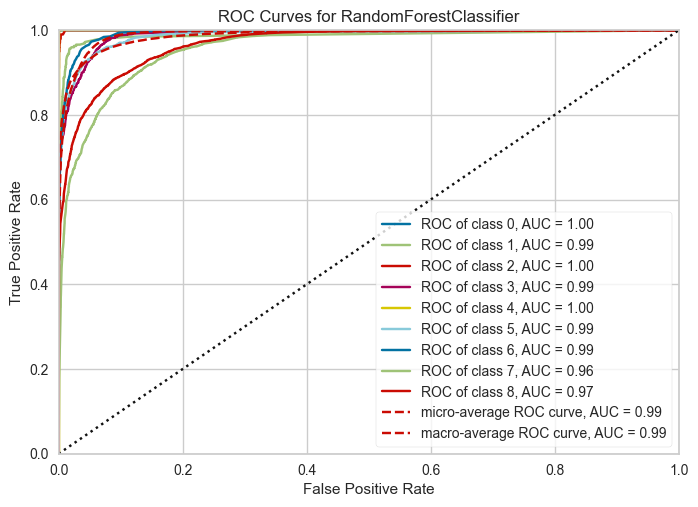

In [66]:
plot_model(rf_model, plot = 'auc')

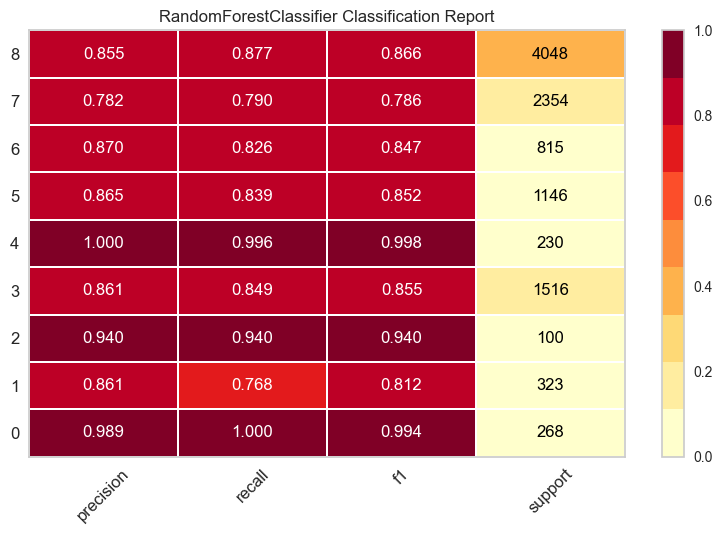

In [67]:
plot_model(rf_model, plot = 'class_report')

Automatically_Searching_Infor: 0, Cross_Site_Scripting: 1, Directory_Indexing: 2, HOST_Scan: 3, Leakage_Through_NW: 4, Path_Disclosure: 5, SQL_Injection: 6, System_Cmd_Execution: 7, Vulnerability_Scan: 8


In [31]:
data.label_action.unique()

array(['System_Cmd_Execution', 'SQL_Injection', 'HOST_Scan',
       'Vulnerability_Scan', 'Path_Disclosure', 'Cross_Site_Scripting',
       'Leakage_Through_NW', 'Directory_Indexing',
       'Automatically_Searching_Infor'], dtype=object)

In [38]:
data[data['label_action'] == data.label_action.unique()[6]]['decoded_payload'].to_csv('Leakage_Through_NW.csv', index=False)

In [39]:
data[data['label_action'] == data.label_action.unique()[0]]['decoded_payload'].to_csv('System_Cmd_Execution.csv', index=False)

In [71]:
predict_model(rf_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8281,0.9662,0.8281,0.8281,0.8277,0.7765,0.7766


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,6880,6881,6882,6883,6884,6885,6886,6887,6888,6889,6890,6891,6892,6893,6894,6895,6896,6897,6898,6899,6900,6901,6902,6903,6904,6905,6906,6907,6908,6909,6910,6911,6912,6913,6914,6915,6916,6917,6918,6919,6920,6921,6922,6923,6924,6925,6926,6927,6928,6929,6930,6931,6932,6933,6934,6935,6936,6937,6938,6939,6940,6941,6942,6943,6944,6945,6946,6947,6948,6949,6950,6951,6952,6953,6954,6955,6956,6957,6958,6959,6960,6961,6962,6963,6964,6965,6966,6967,6968,6969,6970,6971,6972,6973,6974,6975,6976,6977,6978,6979,6980,6981,6982,6983,6984,6985,6986,6987,6988,6989,6990,6991,6992,6993,6994,6995,6996,6997,6998,6999,7000,7001,7002,7003,7004,7005,7006,7007,7008,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048,7049,7050,7051,7052,7053,7054,7055,7056,7057,7058,7059,7060,7061,7062,7063,7064,7065,7066,7067,7068,7069,7070,7071,7072,7073,7074,7075,7076,7077,7078,7079,7080,7081,7082,7083,7084,7085,7086,7087,7088,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,label_action,prediction_label,prediction_score
31168,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036517,0.0,0.0,0.071347,0.0,0.0,0.0,0.0,0.0,0.0,

### Added Custom features

In [57]:
clf1 = setup(data=pd.concat([merged_df, y_train], axis=1), target = 'label_action', session_id=2023, fold=5, n_jobs=-1)

,Description,Value
0,Session id,2023
1,Target,label_action
2,Target type,Multiclass
3,Target mapping,"Automatically_Searching_Infor: 0, Cross_Site_Scripting: 1, Directory_Indexing: 2, HOST_Scan: 3, Leakage_Through_NW: 4, Path_Disclosure: 5, SQL_Injection: 6, System_Cmd_Execution: 7, Vulnerability_Scan: 8"
4,Original data shape,"(36000, 1011)"
5,Transformed data shape,"(36000, 1011)"
6,Transformed train set shape,"(25200, 1011)"
7,Transformed test set shape,"(10800, 1011)"
8,Numeric features,1010
9,Preprocess,True


In [58]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8179,0.9661,0.8179,0.8175,0.8174,0.7634,0.7635
1,0.8075,0.9631,0.8075,0.8070,0.8069,0.7496,0.7499
2,0.8167,0.9644,0.8167,0.8164,0.8163,0.7617,0.7619
3,0.8153,0.9646,0.8153,0.8153,0.8152,0.7605,0.7605
4,0.8181,0.9661,0.8181,0.8187,0.8179,0.7636,0.7637
Mean,0.8151,0.9649,0.8151,0.8150,0.8147,0.7598,0.7599
Std,0.0039,0.0011,0.0039,0.0041,0.0040,0.0052,0.0052
